<a href="https://colab.research.google.com/github/rafkama/Magang-BVK/blob/main/Perbandingan_Model_untuk_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Membandingkan Berbagai Model***

Pada laporan kali ini dilakukan perbandingan model menggunakan data yang sama. Data yang digunakan berasal dari data penjualan kopi perharinya.

## **Import Library**

In [93]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.layers import Conv1D, MaxPooling1D, RepeatVector, TimeDistributed, Flatten
import os

# Ignore warnings
warnings.filterwarnings('ignore')

# Initialize notebook mode for offline Plotly
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Enable inline plotting
%matplotlib inline

## **Import Dataset**

Berdasarkan data yang di-import, akan dilakukan prediksi terhadap kolom money (sales) terhadap datetime (waktu). Algoritma prediksi akan dilakukan untuk membandingkan data prediksi dan data aktual.

In [94]:

#Menampilkan sebagian data
df = pd.read_csv('index.csv')
df.head(5)


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1830 non-null   object 
 1   datetime     1830 non-null   object 
 2   cash_type    1830 non-null   object 
 3   card         1741 non-null   object 
 4   money        1830 non-null   float64
 5   coffee_name  1830 non-null   object 
dtypes: float64(1), object(5)
memory usage: 85.9+ KB


## **Preprocessing**

In [96]:
df.isnull().sum().sort_values(ascending=False)

,0
card,89
date,0
datetime,0
cash_type,0
money,0
coffee_name,0


In [97]:
df.duplicated().any() # use df.drop_duplicates(inplace=True) -> if any duplicates exist in the dataframe

False

In [98]:

# removing missing values
df.dropna(axis=0, inplace=True)

In [99]:
df

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.70,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.70,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.70,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.70,Latte
...,...,...,...,...,...,...
1825,2024-10-07,2024-10-07 14:32:38.765,card,ANON-0000-0000-0728,25.96,Americano
1826,2024-10-07,2024-10-07 17:48:55.006,card,ANON-0000-0000-0494,35.76,Latte
1827,2024-10-07,2024-10-07 21:14:42.130,card,ANON-0000-0000-0636,35.76,Hot Chocolate
1828,2024-10-07,2024-10-07 21:15:20.122,card,ANON-0000-0000-0636,35.76,Hot Chocolate


Convert to datetime

In [100]:
# Convert 'datetime' column to pandas datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract useful features from 'datetime'
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['day_of_week'] = df['datetime'].dt.weekday  # 0 = Monday, 6 = Sunday

# Drop the original 'datetime' column as it's no longer needed
df = df.drop(['datetime'], axis=1)

# Now you can include these new numeric columns for feature scaling or other processing


In [101]:
df

,date,cash_type,card,money,coffee_name,year,month,day,hour,minute,day_of_week
0,2024-03-01,card,ANON-0000-0000-0001,38.70,Latte,2024,3,1,10,15,4
1,2024-03-01,card,ANON-0000-0000-0002,38.70,Hot Chocolate,2024,3,1,12,19,4
2,2024-03-01,card,ANON-0000-0000-0002,38.70,Hot Chocolate,2024,3,1,12,20,4
3,2024-03-01,card,ANON-0000-0000-0003,28.90,Americano,2024,3,1,13,46,4
4,2024-03-01,card,ANON-0000-0000-0004,38.70,Latte,2024,3,1,13,48,4
...,...,...,...,...,...,...,...,...,...,...,...
1825,2024-10-07,card,ANON-0000-0000-0728,25.96,Americano,2024,10,7,14,32,0
1826,2024-10-07,card,ANON-0000-0000-0494,35.76,Latte,2024,10,7,17,48,0
1827,2024-10-07,card,ANON-0000-0000-0636,35.76,Hot Chocolate,2024,10,7,21,14,0
1828,2024-10-07,card,ANON-0000-0000-0636,35.76,Hot Chocolate,2024,10,7,21,15,0


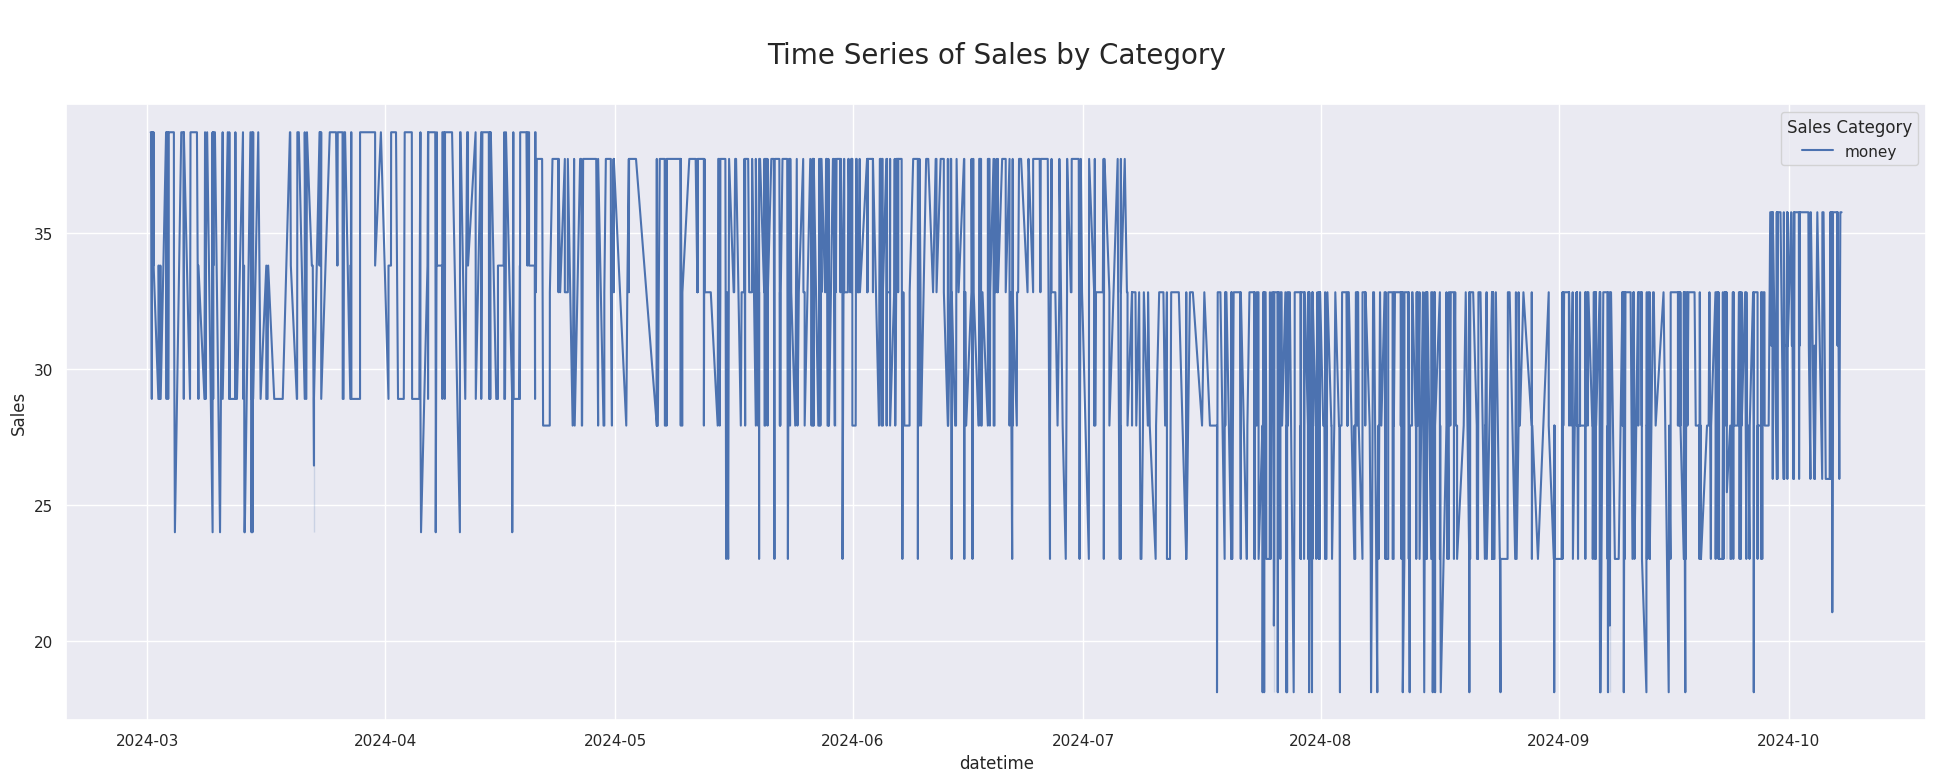

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Recreate the 'datetime' column by combining year, month, day, hour, and minute
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
#df['datetime'] = pd.to_datetime(df[['datetime']])

# Select the columns for reshaping
columns_to_plot = ['money']  # Choose the data you want to plot

# Melt the DataFrame to long format
df_melted = df.melt(id_vars=['datetime'], value_vars=columns_to_plot,
                    var_name='Sales Category', value_name='Sales')

# Set figure size
sns.set(rc={'figure.figsize': (24, 8)})

# Create the line plot using 'datetime'
ax = sns.lineplot(data=df_melted, x='datetime', y='Sales', hue='Sales Category')

# Set the plot title
ax.set_title("\nTime Series of Sales by Category\n", fontsize=20)

# Show the plot
plt.show()


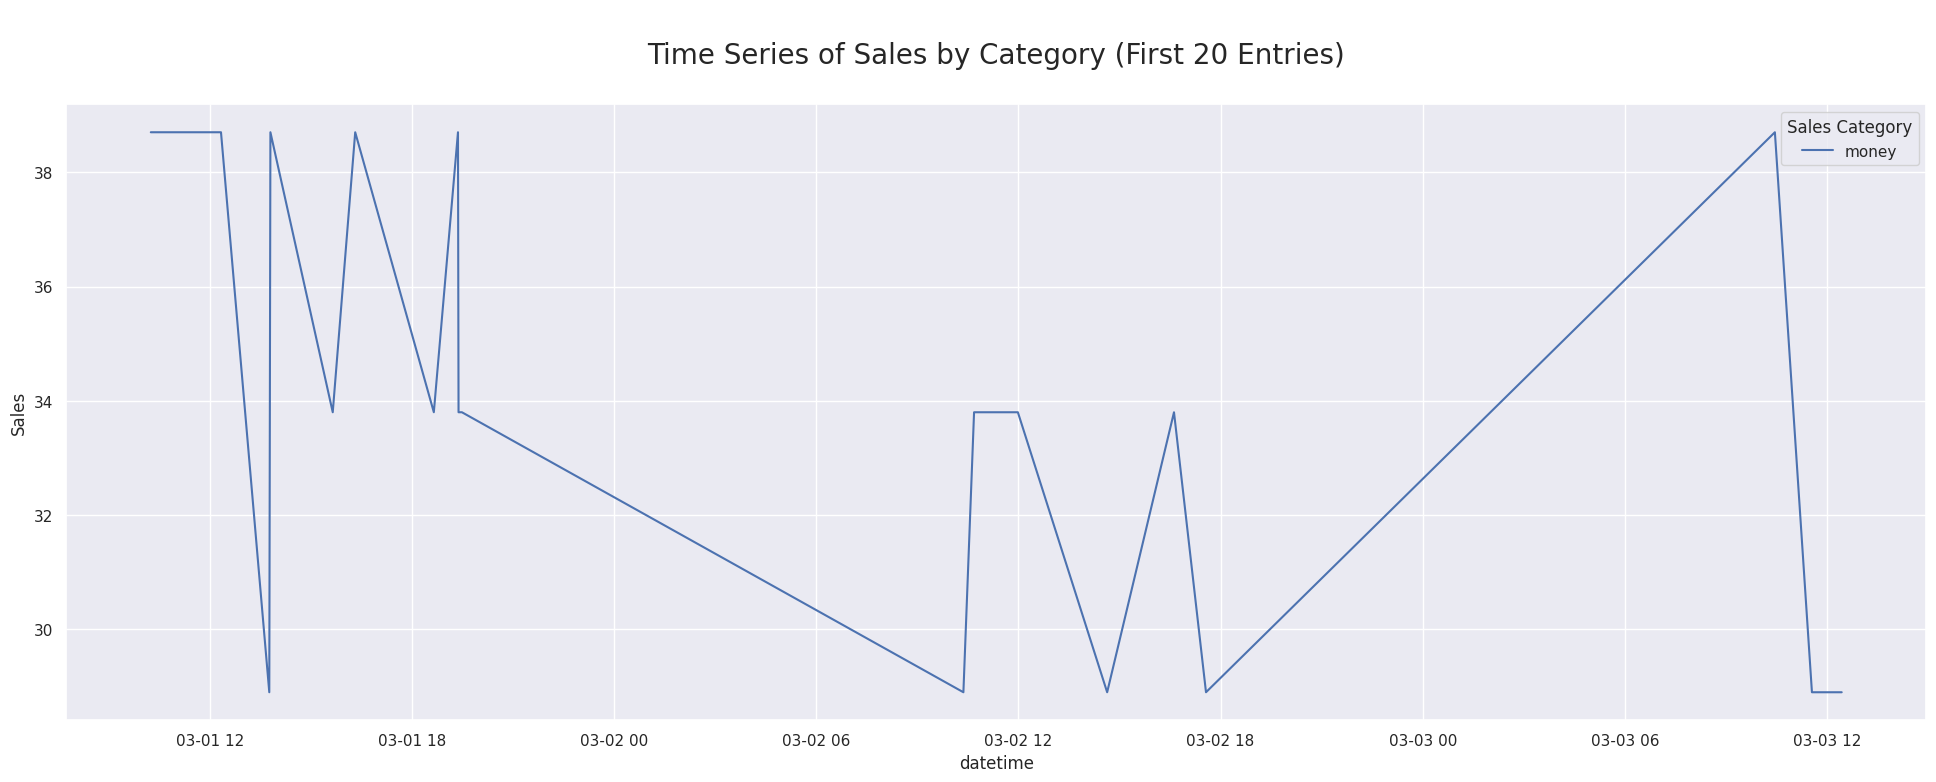

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Recreate the 'datetime' column by combining year, month, day, hour, and minute
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# Select the columns for reshaping
columns_to_plot = ['money']  # Choose the data you want to plot

# Melt the DataFrame to long format
df_melted = df.melt(id_vars=['datetime'], value_vars=columns_to_plot,
                    var_name='Sales Category', value_name='Sales')

# Select the first 15 rows of the melted DataFrame
df_melted_first_15 = df_melted.head(20)

# Set figure size
sns.set(rc={'figure.figsize': (24, 8)})

# Create the line plot using 'datetime'
ax = sns.lineplot(data=df_melted_first_15, x='datetime', y='Sales', hue='Sales Category')

# Set the plot title
ax.set_title("\nTime Series of Sales by Category (First 20 Entries)\n", fontsize=20)

# Show the plot
plt.show()


In [104]:
df

,date,cash_type,card,money,coffee_name,year,month,day,hour,minute,day_of_week,datetime
0,2024-03-01,card,ANON-0000-0000-0001,38.70,Latte,2024,3,1,10,15,4,2024-03-01 10:15:00
1,2024-03-01,card,ANON-0000-0000-0002,38.70,Hot Chocolate,2024,3,1,12,19,4,2024-03-01 12:19:00
2,2024-03-01,card,ANON-0000-0000-0002,38.70,Hot Chocolate,2024,3,1,12,20,4,2024-03-01 12:20:00
3,2024-03-01,card,ANON-0000-0000-0003,28.90,Americano,2024,3,1,13,46,4,2024-03-01 13:46:00
4,2024-03-01,card,ANON-0000-0000-0004,38.70,Latte,2024,3,1,13,48,4,2024-03-01 13:48:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,2024-10-07,card,ANON-0000-0000-0728,25.96,Americano,2024,10,7,14,32,0,2024-10-07 14:32:00
1826,2024-10-07,card,ANON-0000-0000-0494,35.76,Latte,2024,10,7,17,48,0,2024-10-07 17:48:00
1827,2024-10-07,card,ANON-0000-0000-0636,35.76,Hot Chocolate,2024,10,7,21,14,0,2024-10-07 21:14:00
1828,2024-10-07,card,ANON-0000-0000-0636,35.76,Hot Chocolate,2024,10,7,21,15,0,2024-10-07 21:15:00


## **Data Manipulation**

In [105]:
# List of columns to drop
columns_to_drop = ['cash_type', 'date', 'card', 'datetime', 'coffee_name']

# Dropping the specified columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# Display the first few rows of the cleaned DataFrame to verify
print(df.head())


   money  year  month  day  hour  minute  day_of_week
0   38.7  2024      3    1    10      15            4
1   38.7  2024      3    1    12      19            4
2   38.7  2024      3    1    12      20            4
3   28.9  2024      3    1    13      46            4
4   38.7  2024      3    1    13      48            4


**Splitting Data**

In [106]:
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))

df.columns = m
X = df.drop(['money'],axis=1)
Y = df['money']
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (1741, 6) (1741,) 
Training set  --->  (1392, 6) (1392,) 
Testing set   --->  (349, 6)  (349,)


**Feature Scaling**

In [107]:
#Feature Scaling (Standardization)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,year,month,day,hour,minute,day_of_week
count,1392.0,1.392000e+03,1.392000e+03,1.392000e+03,1.392000e+03,1.392000e+03
mean,0.0,1.531342e-17,-3.317908e-17,-2.000316e-16,-4.849250e-17,-7.656711e-17
std,0.0,1.000359e+00,1.000359e+00,1.000359e+00,1.000359e+00,1.000359e+00
min,0.0,-1.729214e+00,-1.629173e+00,-1.710375e+00,-1.745849e+00,-1.458639e+00
25%,0.0,-7.636839e-01,-9.622687e-01,-7.821716e-01,-8.378753e-01,-9.595178e-01
50%,0.0,2.018456e-01,3.808830e-02,-8.601887e-02,-5.096480e-02,3.872493e-02
75%,0.0,6.846104e-01,8.161437e-01,8.421847e-01,7.964773e-01,1.036968e+00
max,0.0,1.650140e+00,1.705350e+00,1.770388e+00,1.825514e+00,1.536089e+00



                                          Standardardization on Testing set                                          


,year,month,day,hour,minute,day_of_week
count,349.0,349.000000,349.000000,349.000000,349.000000,349.000000
mean,0.0,0.030319,0.033311,0.033664,0.051713,0.087350
std,0.0,1.040301,1.022511,1.031419,1.033610,1.024673
min,0.0,-1.729214,-1.629173,-1.710375,-1.745849,-1.458639
25%,0.0,-0.763684,-0.962269,-0.782172,-0.837875,-0.959518
50%,0.0,0.201846,0.149239,-0.086019,0.070098,0.038725
75%,0.0,1.167375,0.927294,1.074236,0.978072,1.036968
max,0.0,1.650140,1.705350,1.770388,1.825514,1.536089


**Feature Selection**

                                       Correlation Matrix                                       


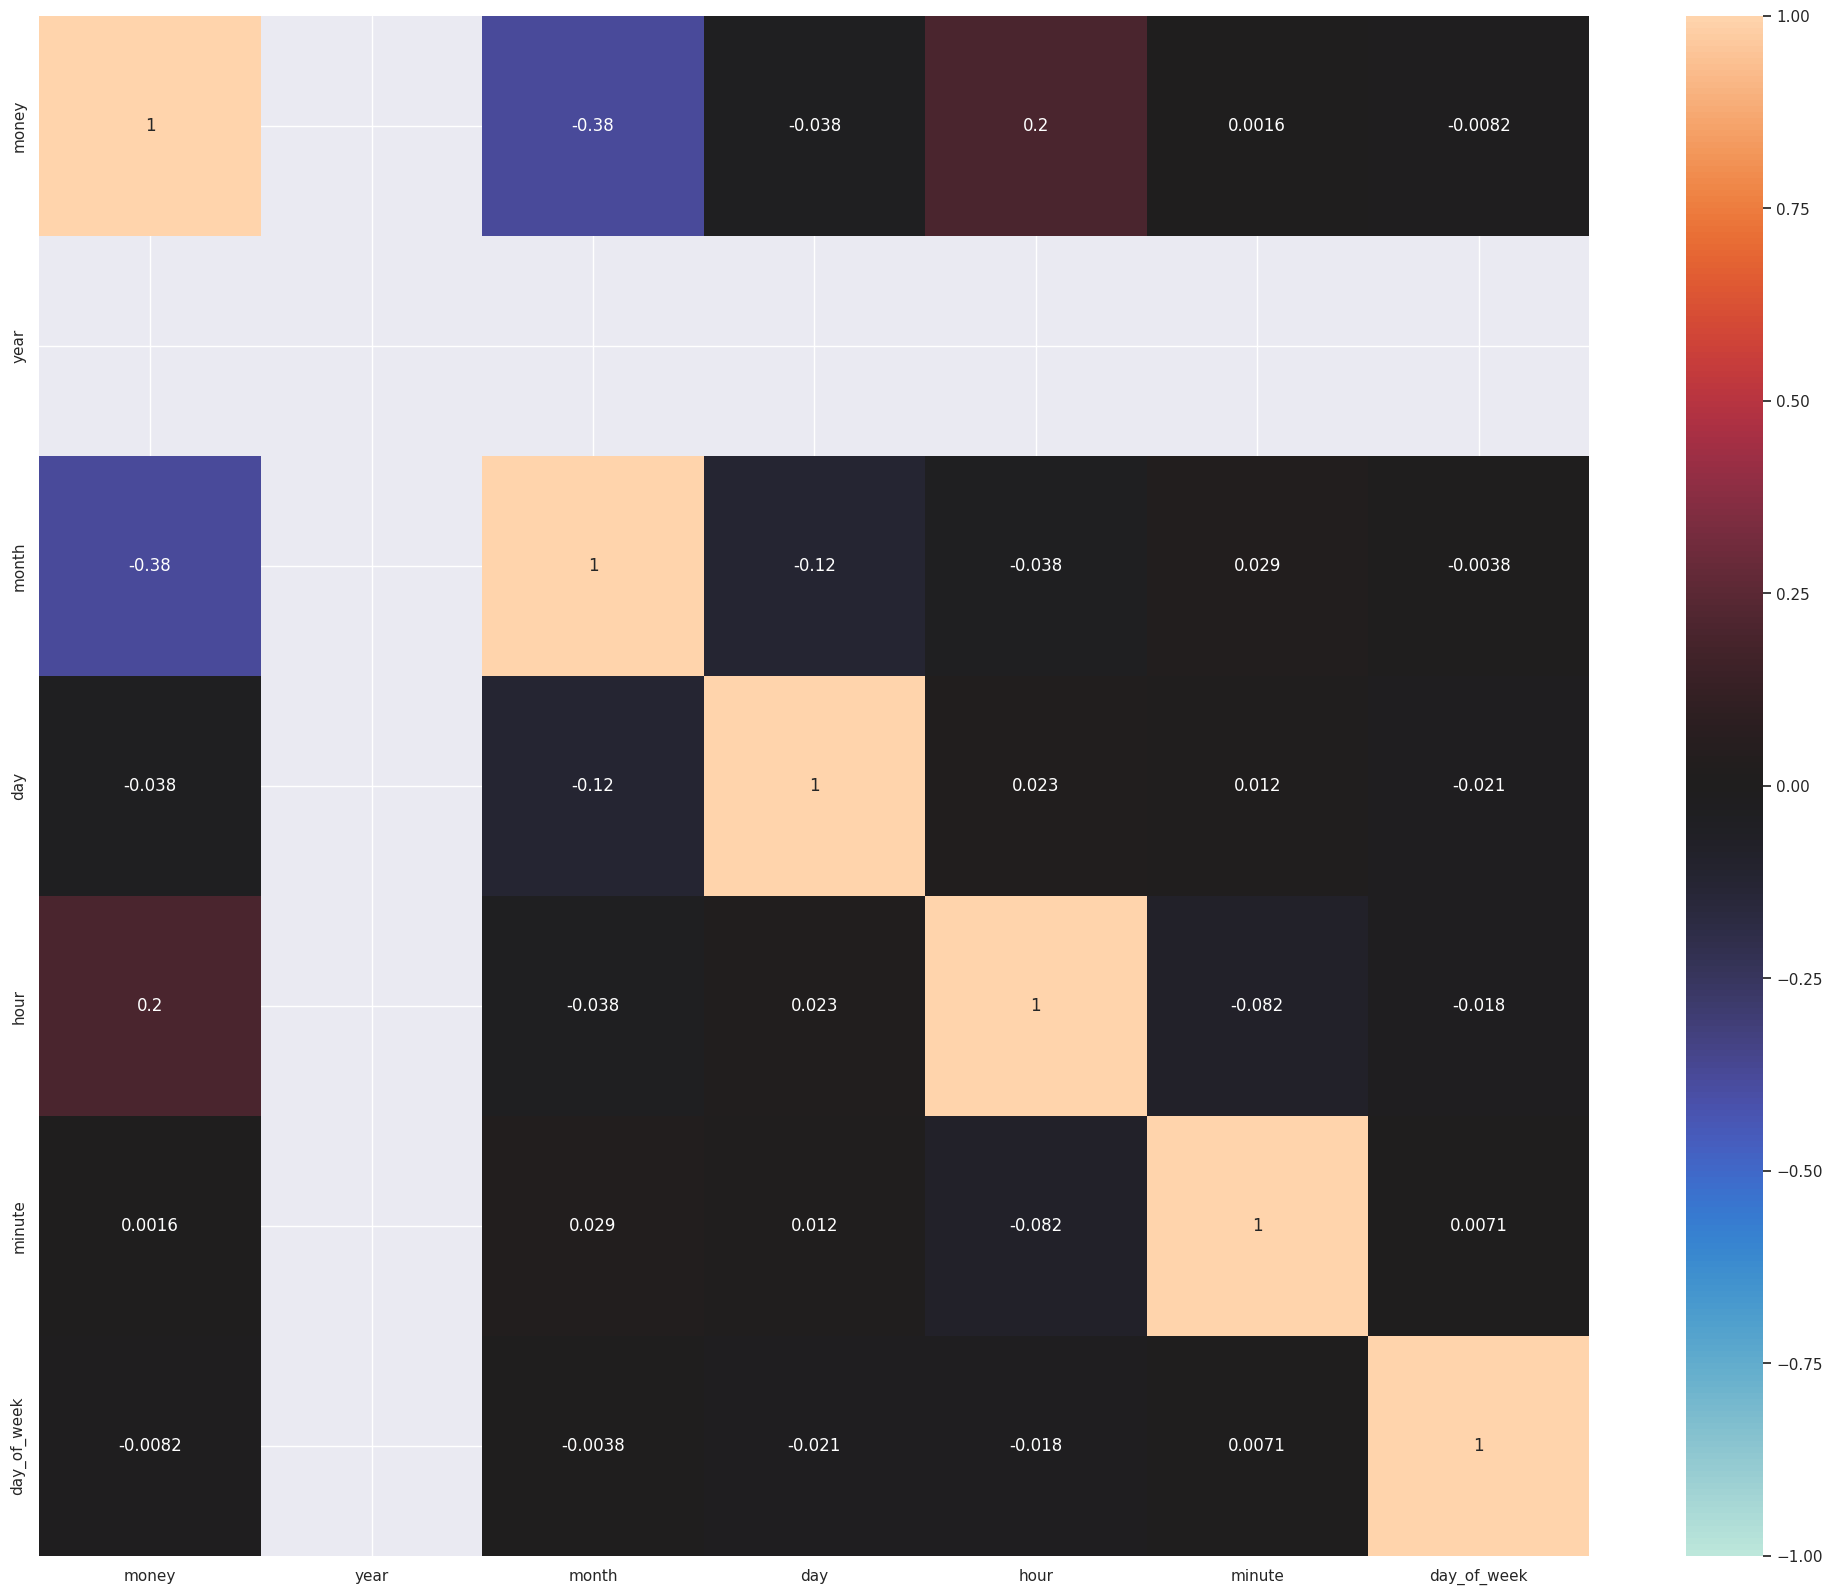

In [108]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

**PCA Decomposition**

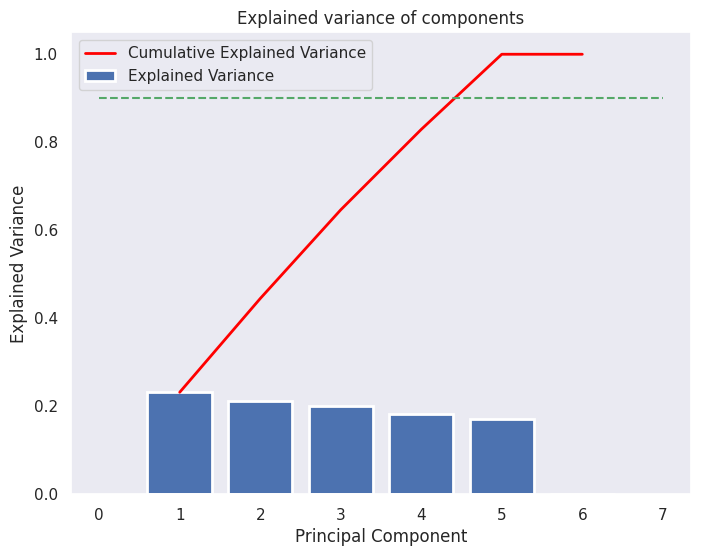

In [109]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

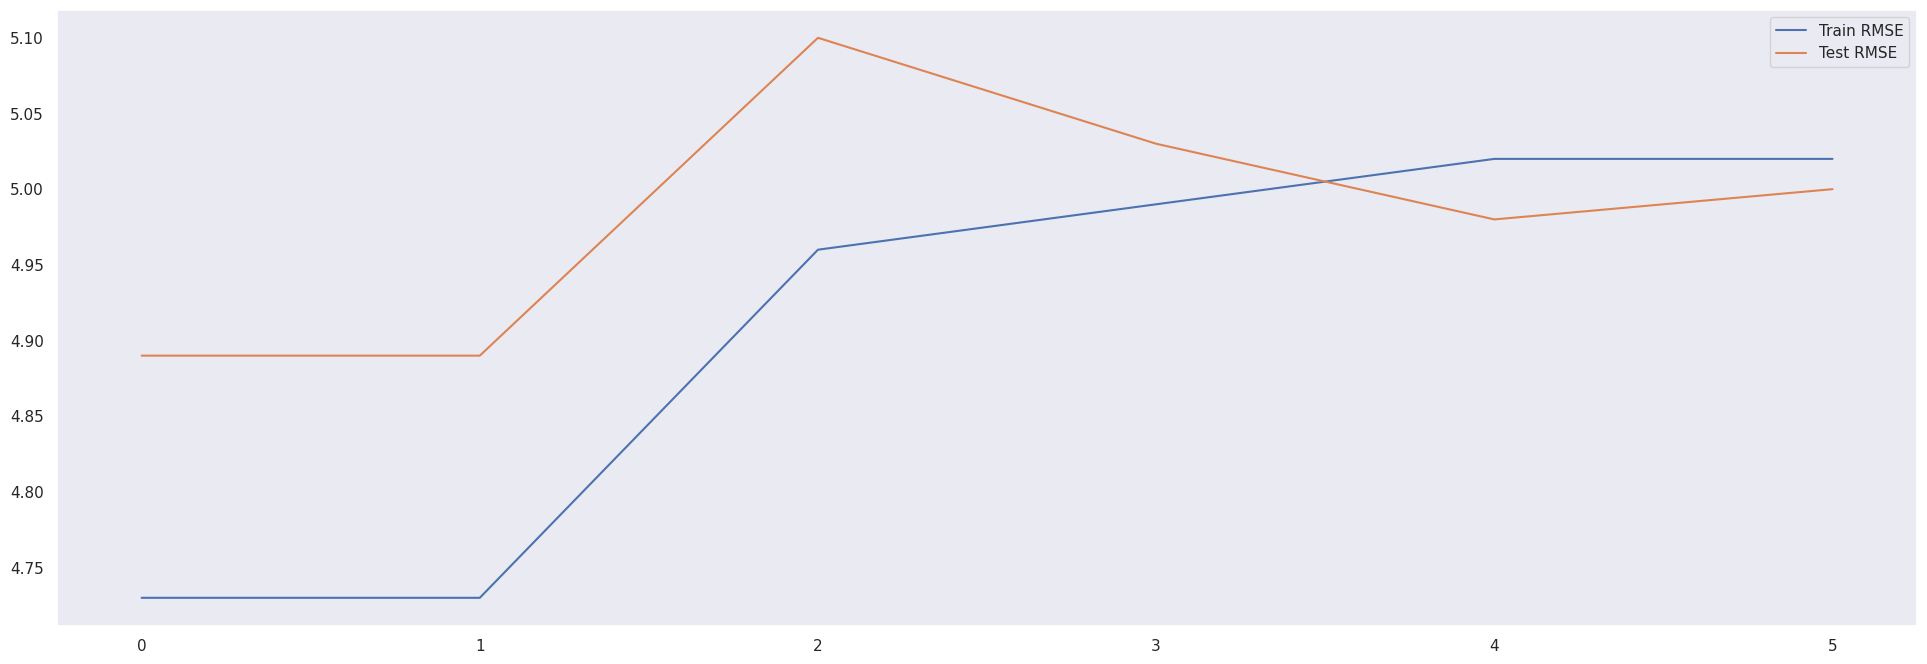

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)

    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

## **Perbandingan Model-Model**

In [111]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=25].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))

    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()


## **MLR**

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  31.290158045977012


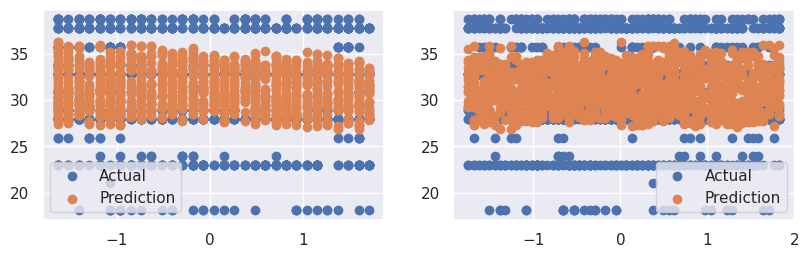



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.1696148898283908
Residual Sum of Squares (RSS) on Training set  ---> 31085.67317021701
Mean Squared Error (MSE) on Training set       ---> 22.33166176021337
Root Mean Squared Error (RMSE) on Training set ---> 4.725638767427465

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.24020368654342883
Residual Sum of Squares (RSS) on Training set  ---> 7533.5845801550595
Mean Squared Error (MSE) on Training set       ---> 21.586202235401316
Root Mean Squared Error (RMSE) on Training set ---> 4.646095375194241

--------------------Residual Plots--------------------


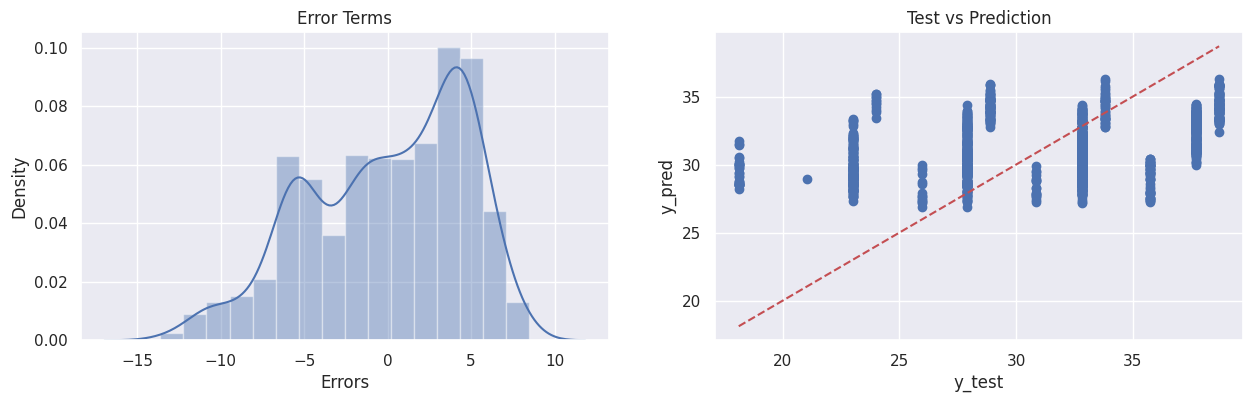

In [112]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

## **RLR**

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  31.290158045977012


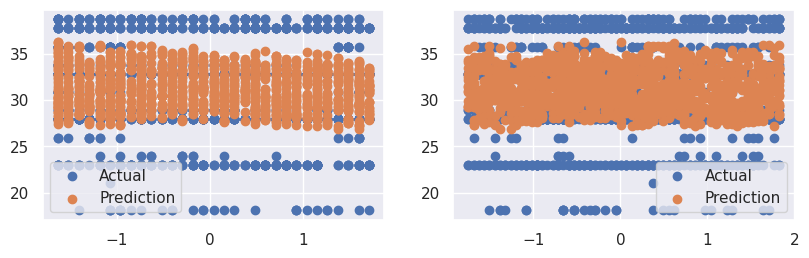



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.1696147935025213
Residual Sum of Squares (RSS) on Training set  ---> 31085.6767761999
Mean Squared Error (MSE) on Training set       ---> 22.33166435071832
Root Mean Squared Error (RMSE) on Training set ---> 4.725639041517911

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.240158887184326
Residual Sum of Squares (RSS) on Training set  ---> 7534.0287778366755
Mean Squared Error (MSE) on Training set       ---> 21.587475008128013
Root Mean Squared Error (RMSE) on Training set ---> 4.646232345473912

--------------------Residual Plots--------------------


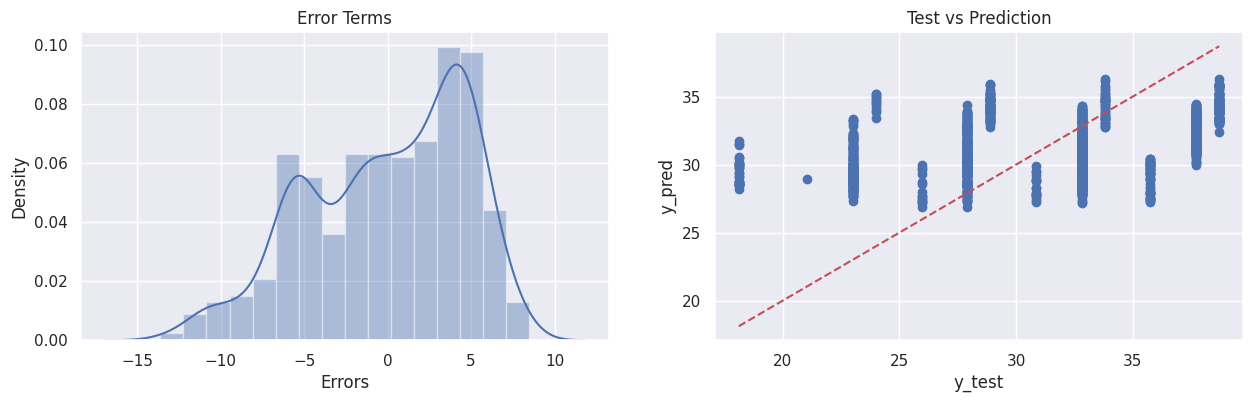

In [113]:
RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)


## **LLR**

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  31.290158045977012


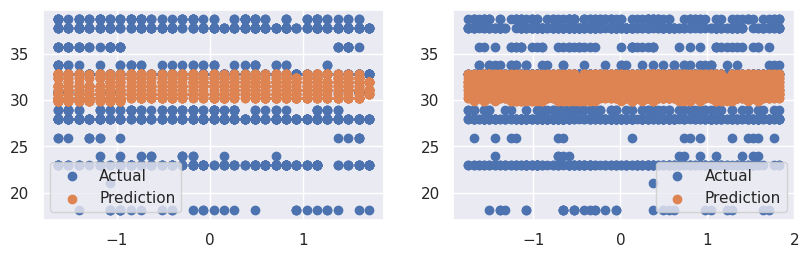



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.0928715522818625
Residual Sum of Squares (RSS) on Training set  ---> 33958.579102345306
Mean Squared Error (MSE) on Training set       ---> 24.395530964328525
Root Mean Squared Error (RMSE) on Training set ---> 4.9391832284628325

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.11685382835229896
Residual Sum of Squares (RSS) on Training set  ---> 8756.631564162471
Mean Squared Error (MSE) on Training set       ---> 25.09063485433373
Root Mean Squared Error (RMSE) on Training set ---> 5.009055285613618

--------------------Residual Plots--------------------


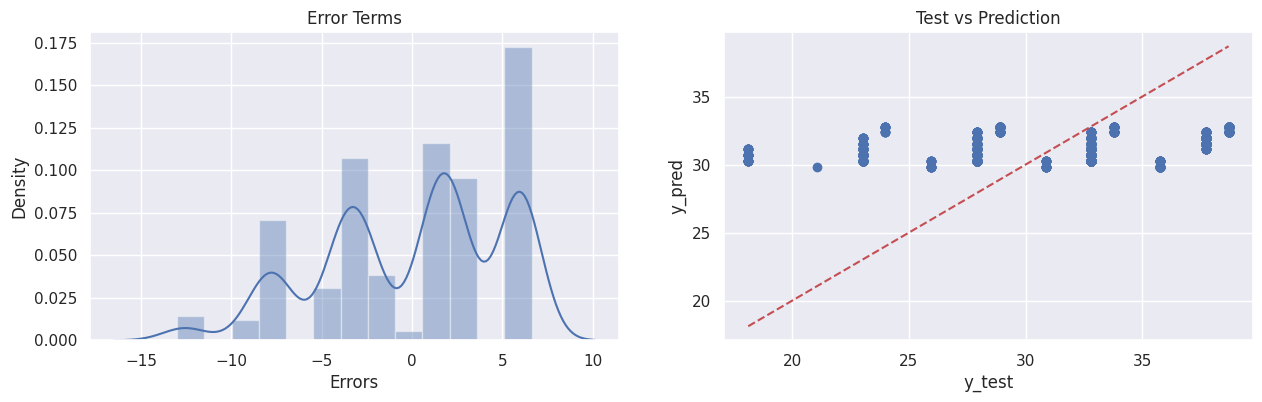

In [114]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

## **ENR**

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  31.290158045977012


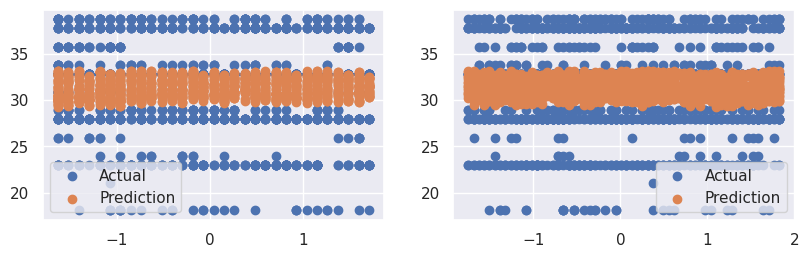



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.11336622400389995
Residual Sum of Squares (RSS) on Training set  ---> 33191.35596806911
Mean Squared Error (MSE) on Training set       ---> 23.84436491958988
Root Mean Squared Error (RMSE) on Training set ---> 4.883069211017788

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.1448853966690018
Residual Sum of Squares (RSS) on Training set  ---> 8478.691033143632
Mean Squared Error (MSE) on Training set       ---> 24.294243647976025
Root Mean Squared Error (RMSE) on Training set ---> 4.928919115584676

--------------------Residual Plots--------------------


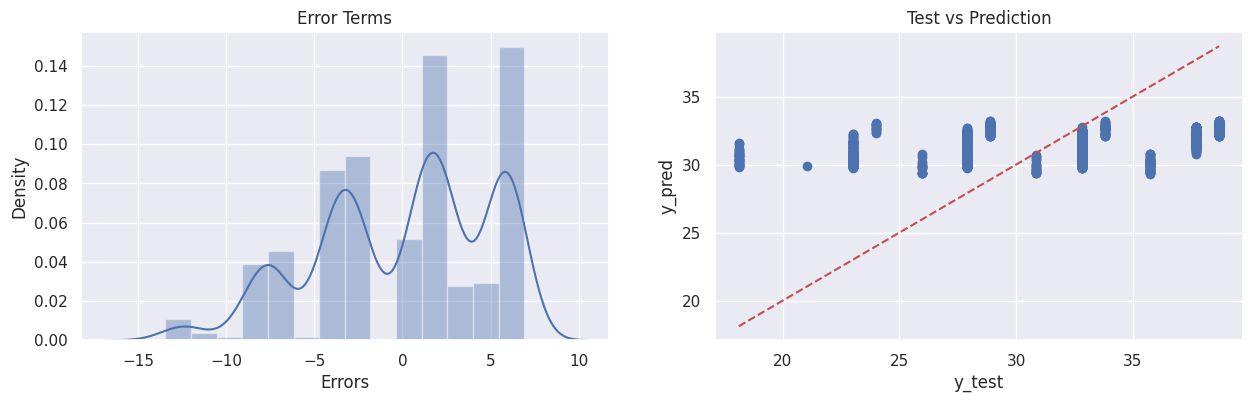

In [115]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

## **PRM**

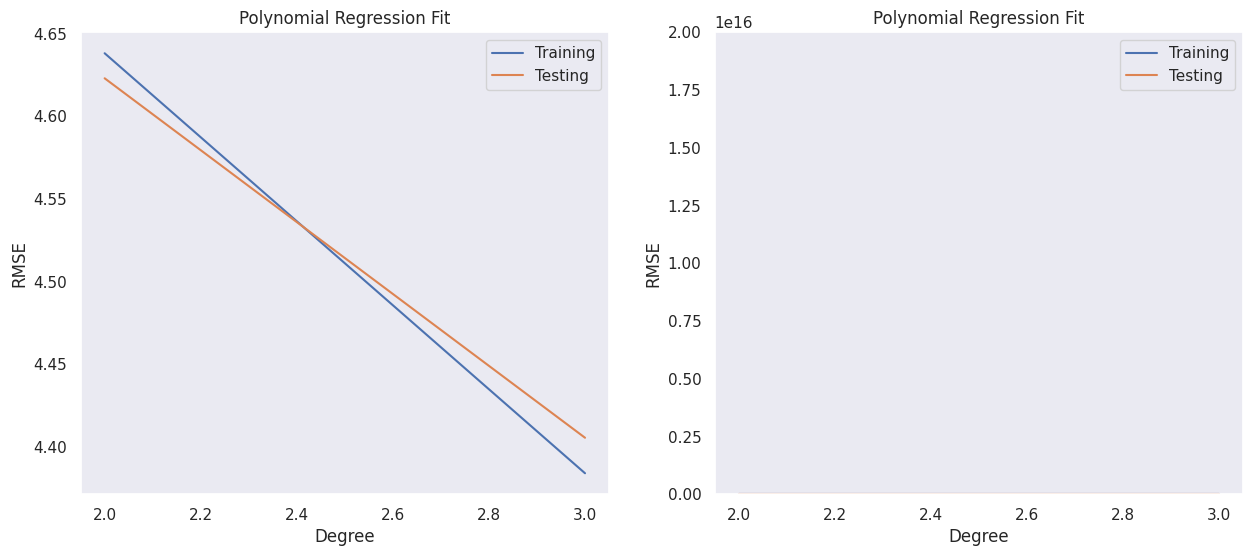

In [116]:
Trr=[]; Tss=[]
n_degree=4

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)

    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))

    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,2e16])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.         -1.91049913 -0.44891682  0.93821176  0.10461948 -0.04157328]
The Intercept of the Regresion Model was found to be  31.290158045977012


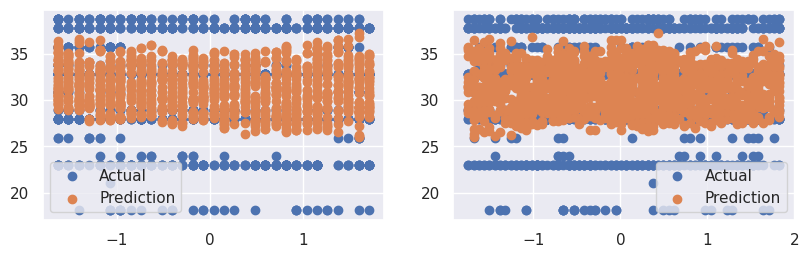



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.20010616865675146
Residual Sum of Squares (RSS) on Training set  ---> 29944.22456210735
Mean Squared Error (MSE) on Training set       ---> 21.51165557622654
Root Mean Squared Error (RMSE) on Training set ---> 4.638065930560554

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.24776505270056137
Residual Sum of Squares (RSS) on Training set  ---> 7458.611603217161
Mean Squared Error (MSE) on Training set       ---> 21.37137995191164
Root Mean Squared Error (RMSE) on Training set ---> 4.6229189860857005

--------------------Residual Plots--------------------


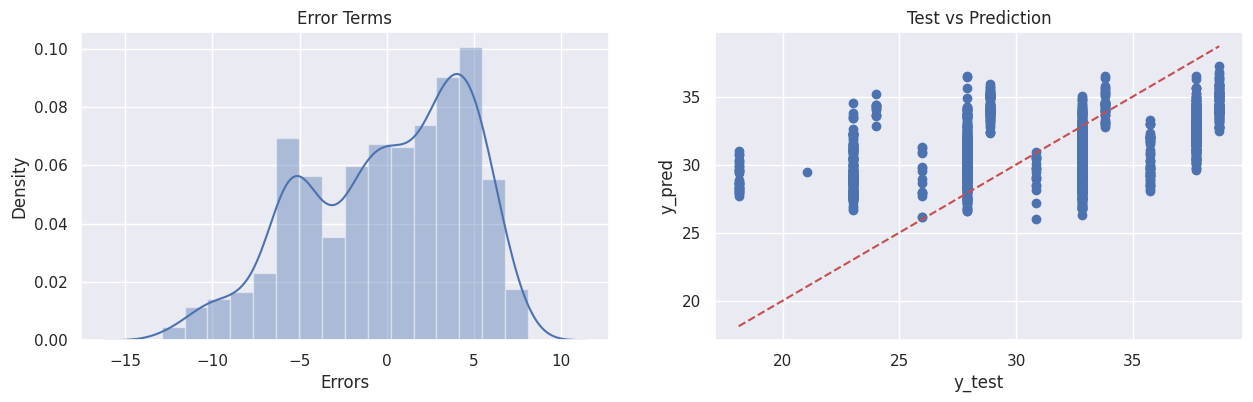

In [117]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)


## **First Evaluation**

In [118]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.169615,0.240204,31085.673170,7533.584580,22.331662,21.586202,4.725639,4.646095
Ridge Linear Regression (RLR),0.169615,0.240159,31085.676776,7534.028778,22.331664,21.587475,4.725639,4.646232
Lasso Linear Regression (LLR),0.092872,0.116854,33958.579102,8756.631564,24.395531,25.090635,4.939183,5.009055
Elastic-Net Regression (ENR),0.113366,0.144885,33191.355968,8478.691033,23.844365,24.294244,4.883069,4.928919
Polynomial Regression (PNR),0.200106,0.247765,29944.224562,7458.611603,21.511656,21.371380,4.638066,4.622919


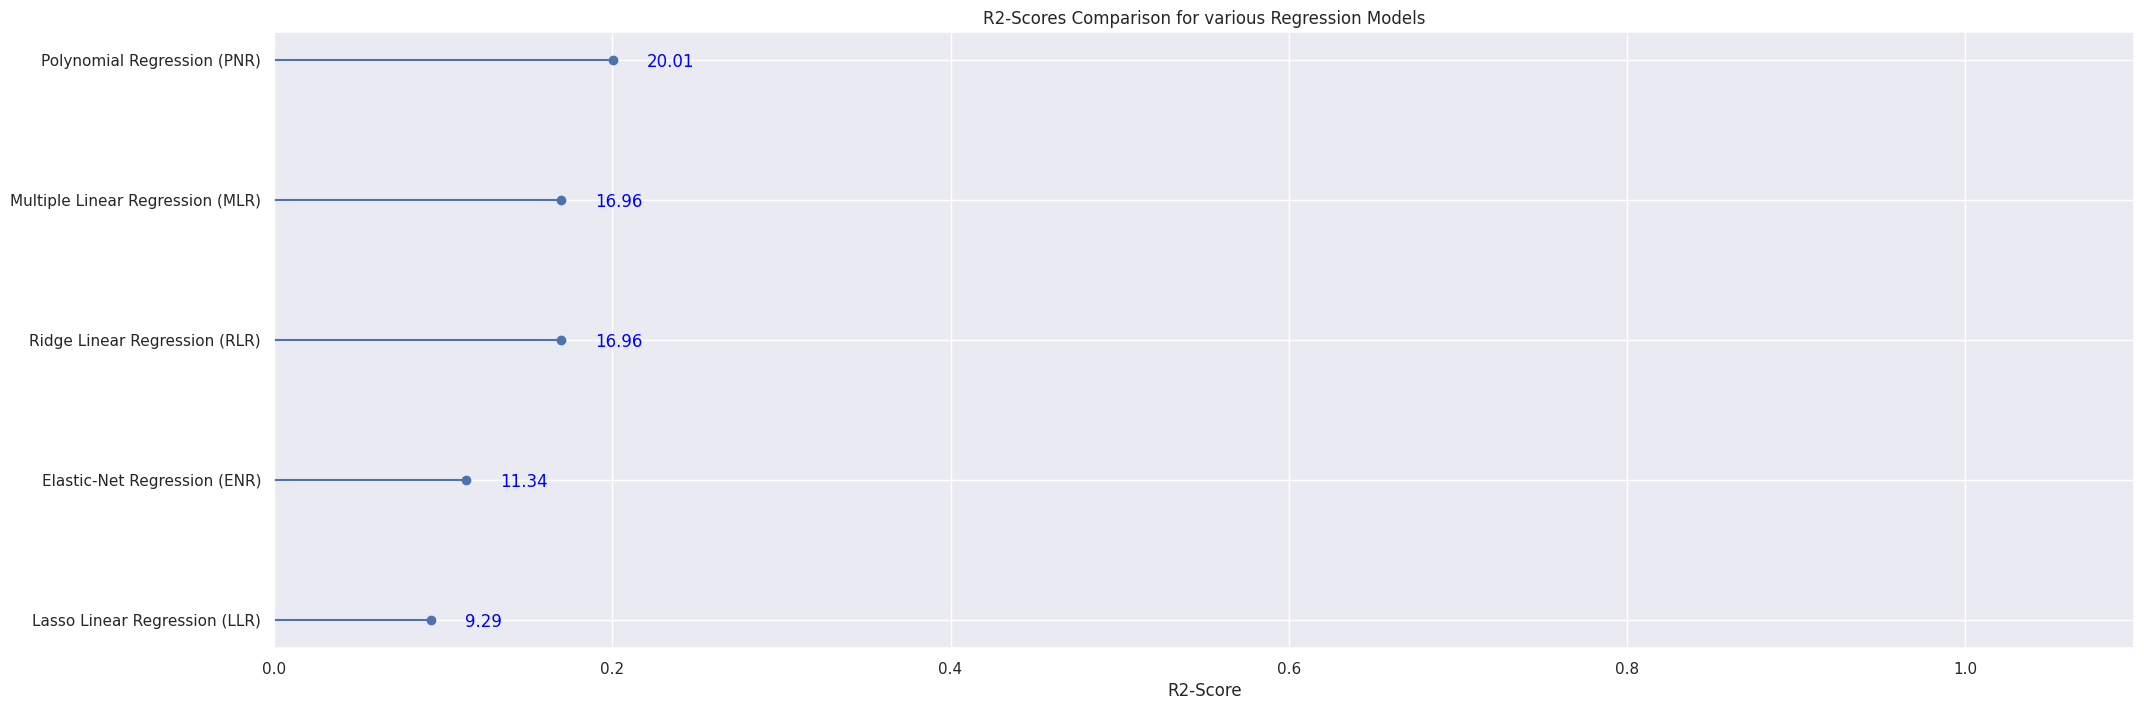

In [119]:
R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

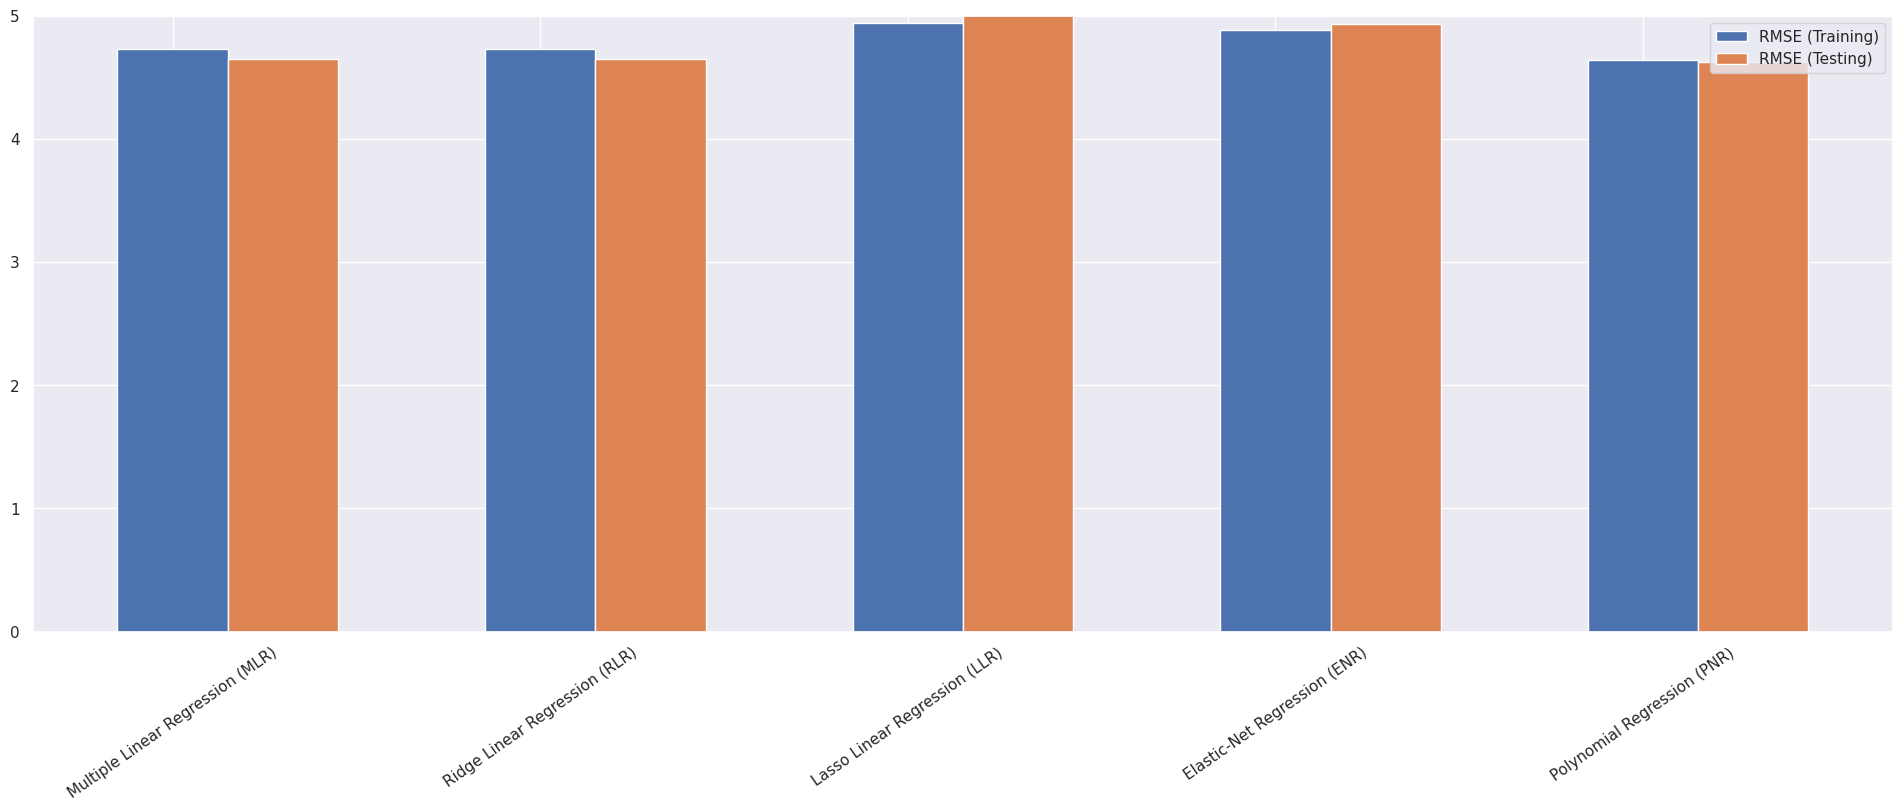

In [120]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5

plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,5])
plt.show()


## **CNN**

In [121]:
X_train_series = Train_X_std.values.reshape((Train_X_std.shape[0], Train_X_std.shape[1], 1))
X_valid_series = Test_X.values.reshape((Test_X.shape[0], Test_X.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1392, 6, 1)
Validation set shape (349, 6, 1)


In [122]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

Y_train = Train_Y
Y_valid = Test_Y

In [123]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 5, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,693 (26.14 KB)

 Trainable params: 6,693 (26.14 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
44/44 - 2s - 44ms/step - loss: 976.0668 - val_loss: 280281.5938
Epoch 2/40
44/44 - 0s - 9ms/step - loss: 877.0063 - val_loss: 2134845.2500
Epoch 3/40
44/44 - 0s - 6ms/step - loss: 737.9360 - val_loss: 7938997.0000
Epoch 4/40
44/44 - 0s - 7ms/step - loss: 552.8058 - val_loss: 21716030.0000
Epoch 5/40
44/44 - 0s - 8ms/step - loss: 348.8739 - val_loss: 47135000.0000
Epoch 6/40
44/44 - 0s - 6ms/step - loss: 183.2547 - val_loss: 80630192.0000
Epoch 7/40
44/44 - 0s - 6ms/step - loss: 96.3299 - val_loss: 107919680.0000
Epoch 8/40
44/44 - 0s - 3ms/step - loss: 69.7711 - val_loss: 118074832.0000
Epoch 9/40
44/44 - 0s - 3ms/step - loss: 63.5118 - val_loss: 116268376.0000
Epoch 10/40
44/44 - 0s - 3ms/step - loss: 60.4219 - val_loss: 111073520.0000
Epoch 11/40
44/44 - 0s - 4ms/step - loss: 57.7546 - val_loss: 105294288.0000
Epoch 12/40
44/44 - 0s - 6ms/step - loss: 55.2839 - val_loss: 99886864.0000
Epoch 13/40
44/44 - 0s - 3ms/step - loss: 52.9990 - val_loss: 94947032.0000
Epoch 14/40
4

## **LSTM**

In [125]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(0.0003))
model_lstm.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)


Epoch 1/40
44/44 - 2s - 49ms/step - loss: 1009.2615 - val_loss: 11601.8613
Epoch 2/40
44/44 - 0s - 9ms/step - loss: 999.3550 - val_loss: 2661390.7500
Epoch 3/40
44/44 - 0s - 5ms/step - loss: 982.5671 - val_loss: 153361312.0000
Epoch 4/40
44/44 - 0s - 7ms/step - loss: 897.8500 - val_loss: 5249991680.0000
Epoch 5/40
44/44 - 0s - 7ms/step - loss: 339.6791 - val_loss: 70338715648.0000
Epoch 6/40
44/44 - 0s - 10ms/step - loss: 67.0133 - val_loss: 130478415872.0000
Epoch 7/40
44/44 - 1s - 13ms/step - loss: 43.3455 - val_loss: 125629227008.0000
Epoch 8/40
44/44 - 1s - 14ms/step - loss: 37.7096 - val_loss: 112367378432.0000
Epoch 9/40
44/44 - 1s - 15ms/step - loss: 33.9081 - val_loss: 101681078272.0000
Epoch 10/40
44/44 - 0s - 10ms/step - loss: 31.2589 - val_loss: 92963348480.0000
Epoch 11/40
44/44 - 0s - 11ms/step - loss: 29.3460 - val_loss: 82030804992.0000
Epoch 12/40
44/44 - 0s - 8ms/step - loss: 27.8872 - val_loss: 76567437312.0000
Epoch 13/40
44/44 - 0s - 5ms/step - loss: 26.7759 - val_l

## **CNN-LSTM**

In [127]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (1392, 2, 3, 1)
Validation set shape (349, 2, 3, 1)


In [128]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(0.0003))

In [129]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


Epoch 1/40
44/44 - 4s - 92ms/step - loss: 996.7615 - val_loss: 56091.5859
Epoch 2/40
44/44 - 1s - 14ms/step - loss: 959.5225 - val_loss: 6218232.5000
Epoch 3/40
44/44 - 0s - 7ms/step - loss: 821.5174 - val_loss: 66475392.0000
Epoch 4/40
44/44 - 0s - 8ms/step - loss: 431.6243 - val_loss: 368323840.0000
Epoch 5/40
44/44 - 0s - 6ms/step - loss: 161.8254 - val_loss: 659923776.0000
Epoch 6/40
44/44 - 0s - 7ms/step - loss: 118.9654 - val_loss: 705958784.0000
Epoch 7/40
44/44 - 0s - 7ms/step - loss: 101.3674 - val_loss: 702818816.0000
Epoch 8/40
44/44 - 0s - 5ms/step - loss: 90.8585 - val_loss: 659183424.0000
Epoch 9/40
44/44 - 0s - 7ms/step - loss: 83.2446 - val_loss: 598448960.0000
Epoch 10/40
44/44 - 0s - 6ms/step - loss: 76.8274 - val_loss: 533999264.0000
Epoch 11/40
44/44 - 0s - 6ms/step - loss: 71.2153 - val_loss: 468118496.0000
Epoch 12/40
44/44 - 0s - 5ms/step - loss: 66.1988 - val_loss: 406448832.0000
Epoch 13/40
44/44 - 0s - 7ms/step - loss: 61.6752 - val_loss: 351218688.0000
Epoch 

## **Second Evaluation**

In [130]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train rmse: 5.511191849351656
Validation rmse: 5996.584015349949


In [131]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train rmse: 4.637325976669712
Validation rmse: 5996.584015349949


In [132]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Train rmse: 4.805672348812352
Validation rmse: 1615.270371199136


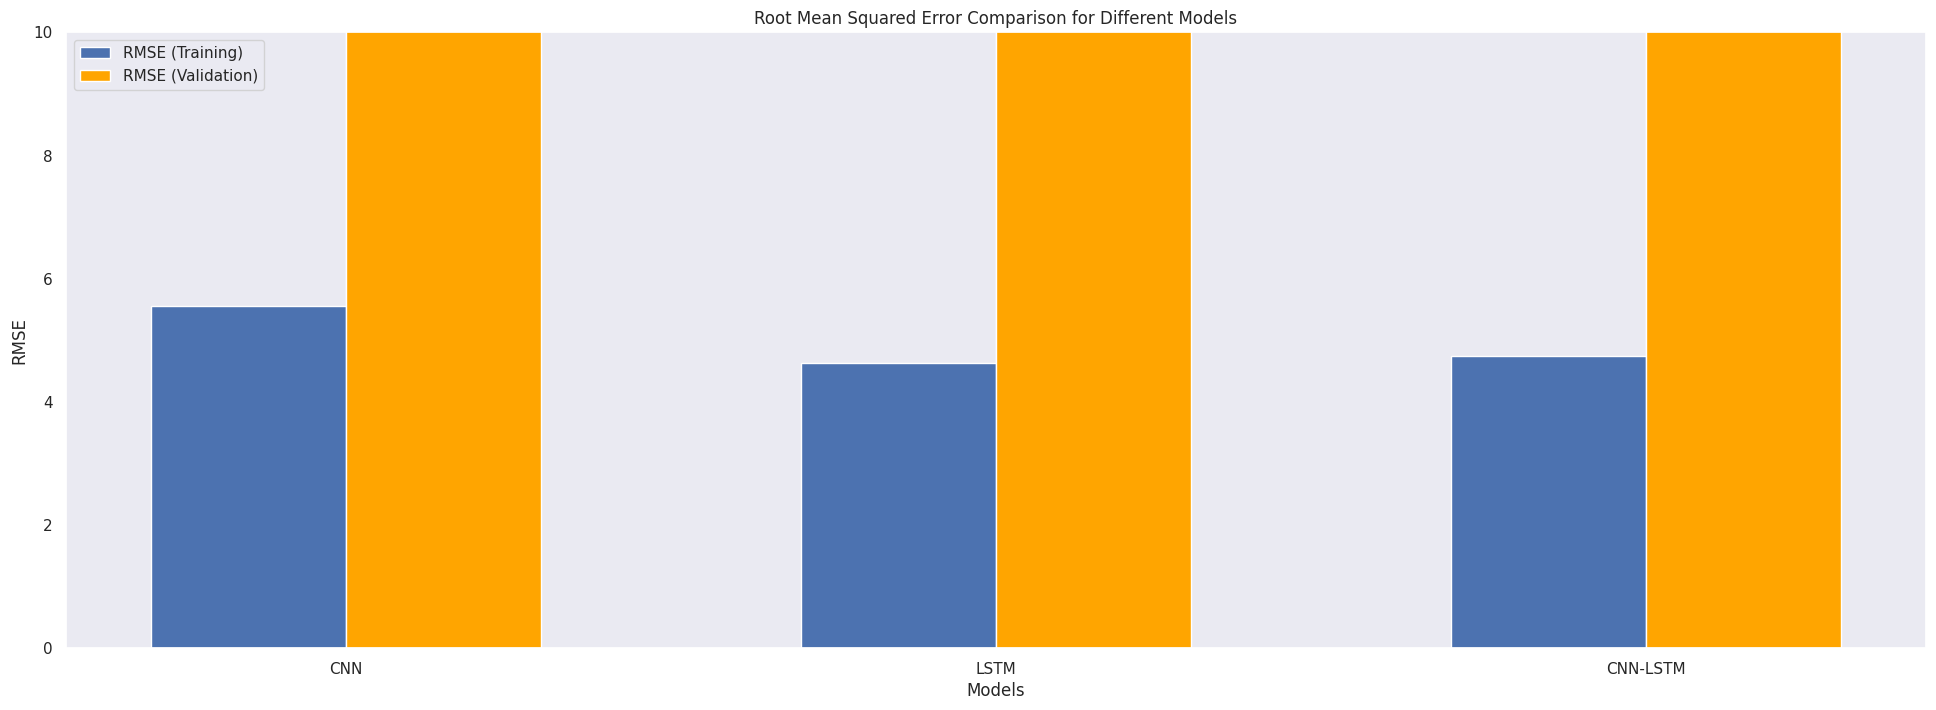

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Create a bar plot
s = 0.3  # Width of the bars
x = np.arange(len(models))  # The label locations

# Create the bar plots
plt.bar(x, train_rmse, width=s, label='RMSE (Training)', color='b')
plt.bar(x + s, valid_rmse, width=s, label='RMSE (Validation)', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error Comparison for Different Models')
plt.xticks(x + s / 2, models)  # Adjust tick positions
plt.ylim([0, max(max(train_rmse), max(valid_rmse)) + 1])  # Adjust y-axis limits
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.ylim([0,10])
plt.show()


## **Summary**

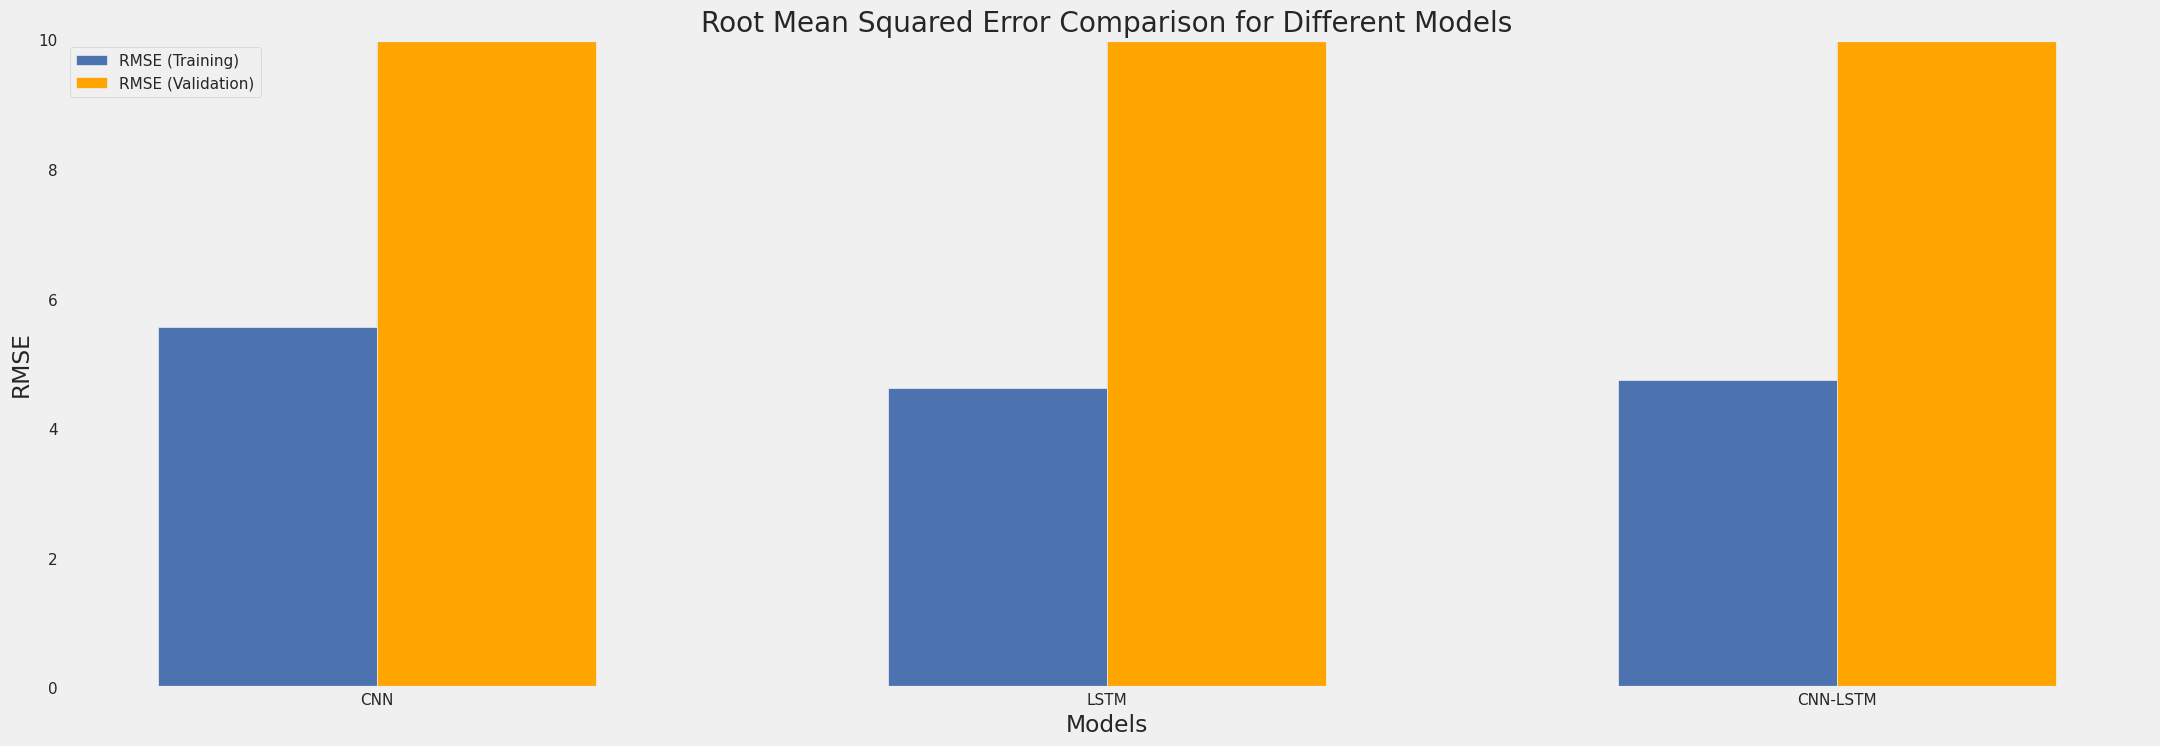

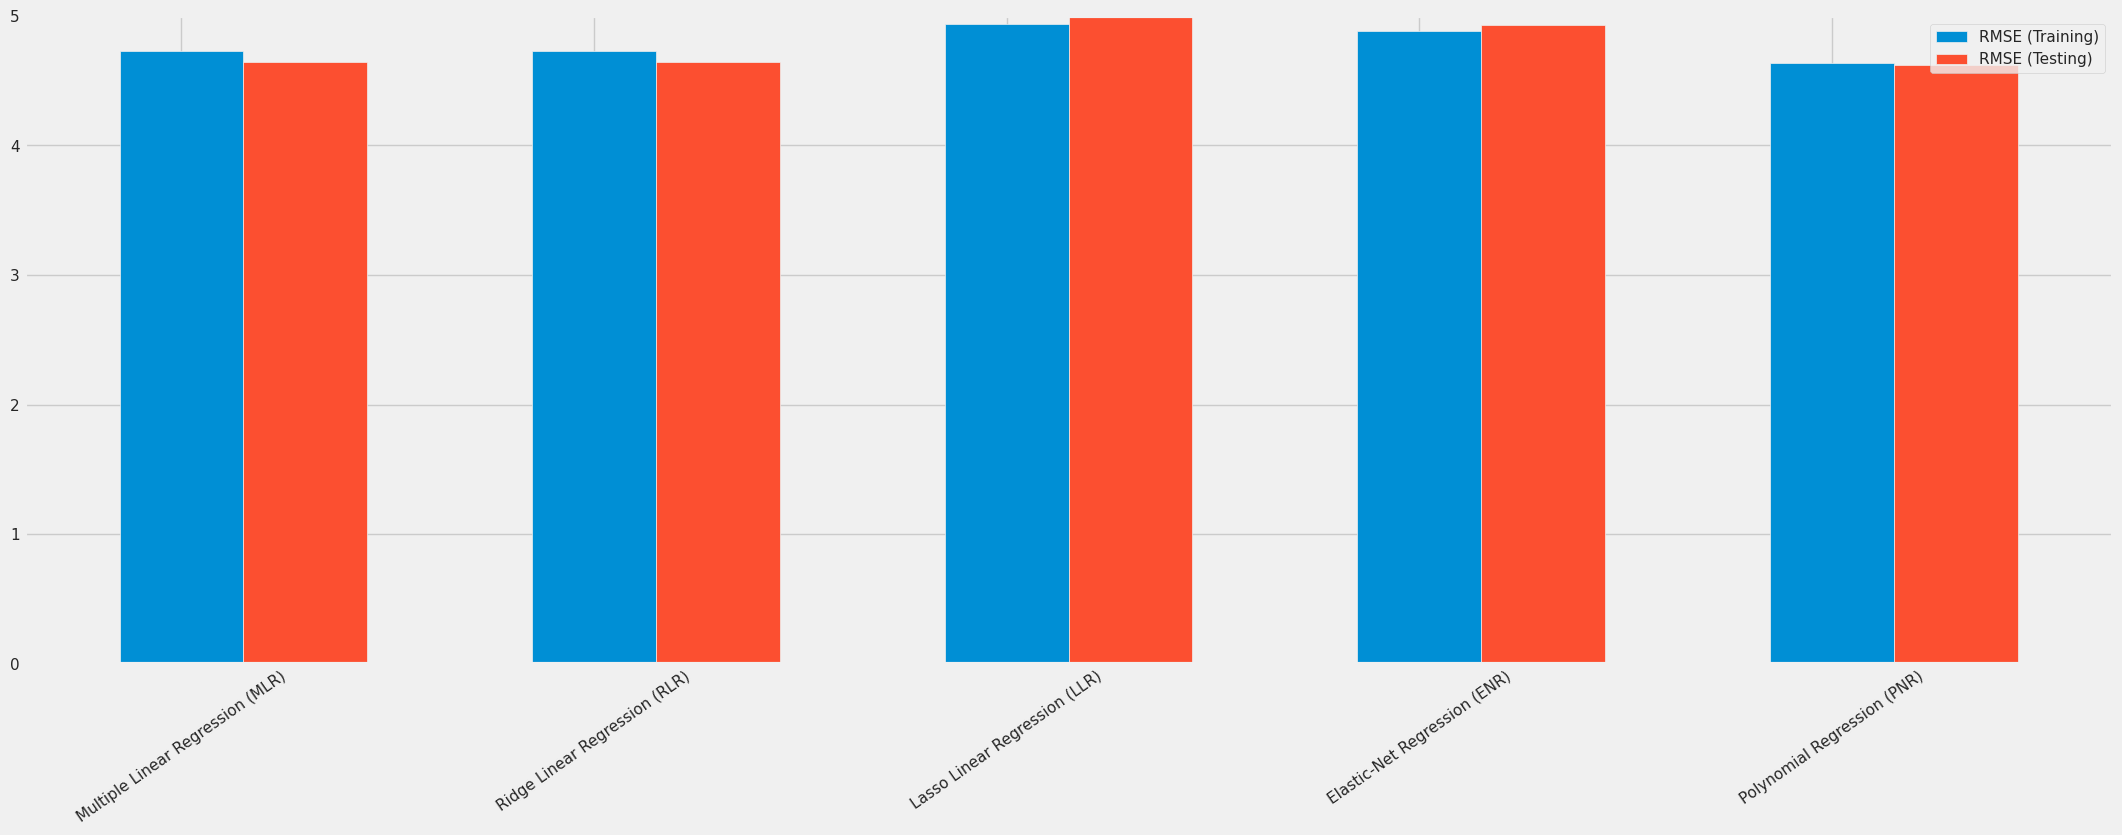

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Create a bar plot
s = 0.3  # Width of the bars
x = np.arange(len(models))  # The label locations

# Create the bar plots
plt.bar(x, train_rmse, width=s, label='RMSE (Training)', color='b')
plt.bar(x + s, valid_rmse, width=s, label='RMSE (Validation)', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error Comparison for Different Models')
plt.xticks(x + s / 2, models)  # Adjust tick positions
plt.ylim([0, max(max(train_rmse), max(valid_rmse)) + 1])  # Adjust y-axis limits
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.ylim([0,10])
plt.show()

# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5

plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,5])
plt.show()
